<a href="https://colab.research.google.com/github/dine1717/EVA6/blob/session6/BN_GN_LN_Assignment_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import seaborn as sns
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
from tqdm import tqdm

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import sys
sys.path.append('/content/drive/MyDrive/Colab Notebooks/')
%cd drive/MyDrive/Colab Notebooks

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks


In [ ]:
# this performs the import from the model.py file
import model

from model import BatchNet
from model import LayerNet
from model import GroupNet


## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [ ]:
train_transforms = transforms.Compose([
                                   transforms.RandomRotation((-12.0, 12.0), fill=(1,)),
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                   ])

test_transforms = transforms.Compose([
                                   transforms.ToTensor(),
                                   transforms.Normalize((0.1307,), (0.3081,))
                                   ])

# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# The model
Let's start with the model we first saw

##### Train and Test functions

In [ ]:
def train(model, device, train_loader, optimizer, epoch, l1_reg=False):
    model.train()
    pbar = tqdm(train_loader)
    
    train_losses = []
    train_acc = []
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      if l1_reg:
        L1_reg = torch.tensor(0., requires_grad=True)
        for name, param in model.named_parameters():
          if 'weight' in name:
            L1_reg = L1_reg + torch.norm(param, 1)
        
        loss = F.nll_loss(y_pred, target) + 10e-4 * L1_reg  
      else :  
        loss = F.nll_loss(y_pred, target)
      
      train_losses.append(loss)

      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)

      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
      train_acc.append(100*correct/processed)

    return train_acc, train_losses



def test(model, device, test_loader):
    model.eval()

    test_losses = []
    test_acc = []
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

    return test_acc, test_losses

In [ ]:
def train_test_display(model, epochs, l1_reg=False):
  train_losses = []
  test_losses = []
  train_acc = []
  test_acc = []

  # model =  model.Net(bn_type).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.1, momentum=0.9)

  # LR Scheduler
  lambda1 = lambda epoch: 0.85 ** epoch
  scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda1)

  for epoch in range(0, epochs):
      print("EPOCH:", epoch+1)
      acc, loss = train(model, device, train_loader, optimizer, epoch, l1_reg)
      # Since accuracy and loss are returned as a list, we expand it using +
      train_acc += acc
      train_losses += loss
      scheduler.step()
      acc, loss = test(model, device, test_loader)
      test_acc += acc
      test_losses += loss

  return test_acc, test_losses, train_acc, train_losses

In [ ]:
# !pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)

cuda


#### Batch Net implementation

In [ ]:
batch_model = BatchNet().to(device)
summary(batch_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
       BatchNorm2d-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
      BatchNorm2d-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
      BatchNorm2d-14             [-1, 1

In [ ]:
EPOCHS=20

In [ ]:
test_acc_bn, test_losses_bn, train_acc_bn, train_losses_bn = train_test_display(batch_model, EPOCHS, l1_reg=True)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.6308355331420898 Batch_id=468 Accuracy=92.12: 100%|██████████| 469/469 [00:16<00:00, 27.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2425, Accuracy: 9270/10000 (92.70%)

EPOCH: 2


Loss=0.5481595993041992 Batch_id=468 Accuracy=95.80: 100%|██████████| 469/469 [00:16<00:00, 27.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2946, Accuracy: 9088/10000 (90.88%)

EPOCH: 3


Loss=0.45242929458618164 Batch_id=468 Accuracy=95.99: 100%|██████████| 469/469 [00:16<00:00, 27.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1592, Accuracy: 9495/10000 (94.95%)

EPOCH: 4


Loss=0.4771379828453064 Batch_id=468 Accuracy=96.22: 100%|██████████| 469/469 [00:16<00:00, 27.63it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1866, Accuracy: 9463/10000 (94.63%)

EPOCH: 5


Loss=0.3305186331272125 Batch_id=468 Accuracy=96.58: 100%|██████████| 469/469 [00:17<00:00, 27.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0865, Accuracy: 9725/10000 (97.25%)

EPOCH: 6


Loss=0.3874001204967499 Batch_id=468 Accuracy=96.72: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0970, Accuracy: 9689/10000 (96.89%)

EPOCH: 7


Loss=0.4031130373477936 Batch_id=468 Accuracy=96.93: 100%|██████████| 469/469 [00:17<00:00, 27.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1069, Accuracy: 9661/10000 (96.61%)

EPOCH: 8


Loss=0.37979400157928467 Batch_id=468 Accuracy=96.84: 100%|██████████| 469/469 [00:17<00:00, 27.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.2286, Accuracy: 9270/10000 (92.70%)

EPOCH: 9


Loss=0.369363933801651 Batch_id=468 Accuracy=97.04: 100%|██████████| 469/469 [00:16<00:00, 27.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0915, Accuracy: 9711/10000 (97.11%)

EPOCH: 10


Loss=0.2938460111618042 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:17<00:00, 27.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0978, Accuracy: 9700/10000 (97.00%)

EPOCH: 11


Loss=0.2957807183265686 Batch_id=468 Accuracy=97.42: 100%|██████████| 469/469 [00:17<00:00, 27.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0801, Accuracy: 9747/10000 (97.47%)

EPOCH: 12


Loss=0.2857438921928406 Batch_id=468 Accuracy=97.43: 100%|██████████| 469/469 [00:17<00:00, 27.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0542, Accuracy: 9834/10000 (98.34%)

EPOCH: 13


Loss=0.2469938099384308 Batch_id=468 Accuracy=97.57: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0993, Accuracy: 9696/10000 (96.96%)

EPOCH: 14


Loss=0.2503845989704132 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:17<00:00, 27.53it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0725, Accuracy: 9760/10000 (97.60%)

EPOCH: 15


Loss=0.21515832841396332 Batch_id=468 Accuracy=97.69: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0626, Accuracy: 9798/10000 (97.98%)

EPOCH: 16


Loss=0.25061002373695374 Batch_id=468 Accuracy=97.76: 100%|██████████| 469/469 [00:17<00:00, 27.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0480, Accuracy: 9852/10000 (98.52%)

EPOCH: 17


Loss=0.22650277614593506 Batch_id=468 Accuracy=97.80: 100%|██████████| 469/469 [00:17<00:00, 27.11it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0726, Accuracy: 9777/10000 (97.77%)

EPOCH: 18


Loss=0.20587432384490967 Batch_id=468 Accuracy=97.99: 100%|██████████| 469/469 [00:16<00:00, 27.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0492, Accuracy: 9844/10000 (98.44%)

EPOCH: 19


Loss=0.2418709546327591 Batch_id=468 Accuracy=98.03: 100%|██████████| 469/469 [00:17<00:00, 27.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0405, Accuracy: 9883/10000 (98.83%)

EPOCH: 20


Loss=0.14676228165626526 Batch_id=468 Accuracy=98.05: 100%|██████████| 469/469 [00:16<00:00, 27.94it/s]



Test set: Average loss: 0.0395, Accuracy: 9868/10000 (98.68%)



In [ ]:
def wrong_predictions(test_loader,model,device):
  wrong_images=[]
  wrong_label=[]
  correct_label=[]
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)        
      pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

      wrong_pred = (pred.eq(target.view_as(pred)) == False)
      wrong_images.append(data[wrong_pred])
      wrong_label.append(pred[wrong_pred])
      correct_label.append(target.view_as(pred)[wrong_pred])  
      
      wrong_predictions = list(zip(torch.cat(wrong_images),torch.cat(wrong_label),torch.cat(correct_label)))    
    print(f'Total wrong predictions are {len(wrong_predictions)}')
      
      
    fig = plt.figure(figsize=(8,10))
    fig.tight_layout()
    for i, (img, pred, correct) in enumerate(wrong_predictions[:10]):
          img, pred, target = img.cpu().numpy(), pred.cpu(), correct.cpu()
          ax = fig.add_subplot(5, 2, i+1)
          ax.axis('off')
          ax.set_title(f'\nactual {target.item()}\npredicted {pred.item()}',fontsize=10)  
          ax.imshow(img.squeeze(), cmap='gray_r')  
          
    plt.show()
      
  return 

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total wrong predictions are 132


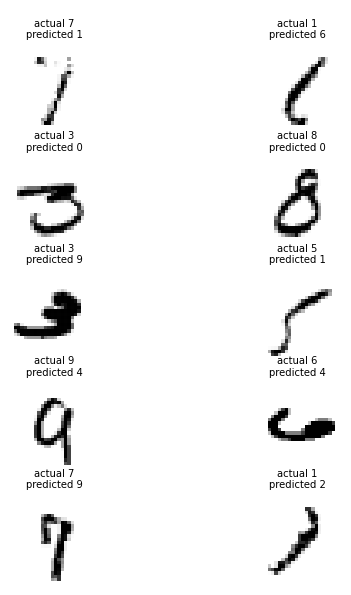

In [ ]:
wrong_predictions(test_loader, batch_model,device=device)

##### Layer model

In [ ]:
layer_model = LayerNet().to(device)
summary(layer_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

In [ ]:
test_acc_ln, test_losses_ln, train_acc_ln, train_losses_ln = train_test_display(layer_model, EPOCHS,l1_reg=False)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.16913412511348724 Batch_id=468 Accuracy=90.57: 100%|██████████| 469/469 [00:16<00:00, 28.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0984, Accuracy: 9687/10000 (96.87%)

EPOCH: 2


Loss=0.08065430819988251 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:16<00:00, 28.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9860/10000 (98.60%)

EPOCH: 3


Loss=0.011889471672475338 Batch_id=468 Accuracy=97.96: 100%|██████████| 469/469 [00:16<00:00, 28.87it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0521, Accuracy: 9835/10000 (98.35%)

EPOCH: 4


Loss=0.018657667562365532 Batch_id=468 Accuracy=98.37: 100%|██████████| 469/469 [00:16<00:00, 28.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9896/10000 (98.96%)

EPOCH: 5


Loss=0.02801513858139515 Batch_id=468 Accuracy=98.50: 100%|██████████| 469/469 [00:16<00:00, 28.70it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

EPOCH: 6


Loss=0.0198835302144289 Batch_id=468 Accuracy=98.70: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0313, Accuracy: 9898/10000 (98.98%)

EPOCH: 7


Loss=0.011986481957137585 Batch_id=468 Accuracy=98.84: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9910/10000 (99.10%)

EPOCH: 8


Loss=0.0076165697537362576 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 29.01it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0316, Accuracy: 9910/10000 (99.10%)

EPOCH: 9


Loss=0.0025040043983608484 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9920/10000 (99.20%)

EPOCH: 10


Loss=0.0627303272485733 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 28.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0242, Accuracy: 9926/10000 (99.26%)

EPOCH: 11


Loss=0.004883724730461836 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:16<00:00, 28.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.008252273313701153 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9924/10000 (99.24%)

EPOCH: 13


Loss=0.03706134483218193 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0230, Accuracy: 9924/10000 (99.24%)

EPOCH: 14


Loss=0.006414132192730904 Batch_id=468 Accuracy=99.19: 100%|██████████| 469/469 [00:16<00:00, 28.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0222, Accuracy: 9928/10000 (99.28%)

EPOCH: 15


Loss=0.0757000595331192 Batch_id=468 Accuracy=99.26: 100%|██████████| 469/469 [00:16<00:00, 28.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9925/10000 (99.25%)

EPOCH: 16


Loss=0.007386688608676195 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 29.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0254, Accuracy: 9921/10000 (99.21%)

EPOCH: 17


Loss=0.012499723583459854 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0240, Accuracy: 9929/10000 (99.29%)

EPOCH: 18


Loss=0.026031725108623505 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9923/10000 (99.23%)

EPOCH: 19


Loss=0.00787888839840889 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0241, Accuracy: 9928/10000 (99.28%)

EPOCH: 20


Loss=0.009392082691192627 Batch_id=468 Accuracy=99.31: 100%|██████████| 469/469 [00:16<00:00, 28.58it/s]



Test set: Average loss: 0.0232, Accuracy: 9929/10000 (99.29%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total wrong predictions are 71


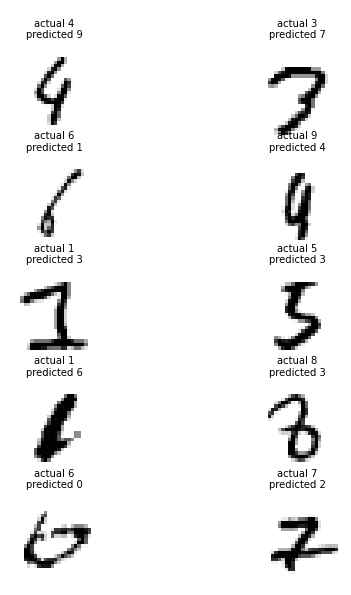

In [ ]:
wrong_predictions(test_loader, layer_model,device=device)

##### Group normalization

In [ ]:
group_model = GroupNet().to(device)
summary(group_model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
         GroupNorm-3            [-1, 8, 26, 26]              16
            Conv2d-4           [-1, 12, 24, 24]             864
              ReLU-5           [-1, 12, 24, 24]               0
         GroupNorm-6           [-1, 12, 24, 24]              24
            Conv2d-7            [-1, 8, 24, 24]              96
         MaxPool2d-8            [-1, 8, 12, 12]               0
            Conv2d-9           [-1, 12, 10, 10]             864
             ReLU-10           [-1, 12, 10, 10]               0
        GroupNorm-11           [-1, 12, 10, 10]              24
           Conv2d-12             [-1, 16, 8, 8]           1,728
             ReLU-13             [-1, 16, 8, 8]               0
        GroupNorm-14             [-1, 1

In [ ]:
test_acc_gn, test_losses_gn,train_acc_gn,train_losses_gn = train_test_display(group_model, EPOCHS)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Loss=0.02501264028251171 Batch_id=468 Accuracy=90.34: 100%|██████████| 469/469 [00:16<00:00, 28.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0642, Accuracy: 9794/10000 (97.94%)

EPOCH: 2


Loss=0.0542171411216259 Batch_id=468 Accuracy=97.53: 100%|██████████| 469/469 [00:16<00:00, 29.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0569, Accuracy: 9829/10000 (98.29%)

EPOCH: 3


Loss=0.2015155702829361 Batch_id=468 Accuracy=98.09: 100%|██████████| 469/469 [00:16<00:00, 28.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0390, Accuracy: 9872/10000 (98.72%)

EPOCH: 4


Loss=0.11561869829893112 Batch_id=468 Accuracy=98.47: 100%|██████████| 469/469 [00:16<00:00, 28.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9867/10000 (98.67%)

EPOCH: 5


Loss=0.01709696464240551 Batch_id=468 Accuracy=98.67: 100%|██████████| 469/469 [00:16<00:00, 28.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9891/10000 (98.91%)

EPOCH: 6


Loss=0.0419885478913784 Batch_id=468 Accuracy=98.82: 100%|██████████| 469/469 [00:16<00:00, 28.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0315, Accuracy: 9903/10000 (99.03%)

EPOCH: 7


Loss=0.11451155692338943 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:16<00:00, 29.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0275, Accuracy: 9914/10000 (99.14%)

EPOCH: 8


Loss=0.002519922563806176 Batch_id=468 Accuracy=99.07: 100%|██████████| 469/469 [00:15<00:00, 29.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0266, Accuracy: 9917/10000 (99.17%)

EPOCH: 9


Loss=0.00884218979626894 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:16<00:00, 29.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9922/10000 (99.22%)

EPOCH: 10


Loss=0.05094205215573311 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:16<00:00, 28.05it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9916/10000 (99.16%)

EPOCH: 11


Loss=0.012392607517540455 Batch_id=468 Accuracy=99.20: 100%|██████████| 469/469 [00:16<00:00, 28.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9923/10000 (99.23%)

EPOCH: 12


Loss=0.00894027017056942 Batch_id=468 Accuracy=99.24: 100%|██████████| 469/469 [00:16<00:00, 28.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.01318667083978653 Batch_id=468 Accuracy=99.28: 100%|██████████| 469/469 [00:16<00:00, 28.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0228, Accuracy: 9930/10000 (99.30%)

EPOCH: 14


Loss=0.03280779346823692 Batch_id=468 Accuracy=99.33: 100%|██████████| 469/469 [00:16<00:00, 28.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9924/10000 (99.24%)

EPOCH: 15


Loss=0.0038976913783699274 Batch_id=468 Accuracy=99.30: 100%|██████████| 469/469 [00:16<00:00, 28.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.013319804333150387 Batch_id=468 Accuracy=99.37: 100%|██████████| 469/469 [00:16<00:00, 28.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9932/10000 (99.32%)

EPOCH: 17


Loss=0.007208636030554771 Batch_id=468 Accuracy=99.36: 100%|██████████| 469/469 [00:16<00:00, 28.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9928/10000 (99.28%)

EPOCH: 18


Loss=0.004979689605534077 Batch_id=468 Accuracy=99.35: 100%|██████████| 469/469 [00:16<00:00, 28.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0216, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.018944839015603065 Batch_id=468 Accuracy=99.42: 100%|██████████| 469/469 [00:16<00:00, 27.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9934/10000 (99.34%)

EPOCH: 20


Loss=0.004806993063539267 Batch_id=468 Accuracy=99.41: 100%|██████████| 469/469 [00:16<00:00, 28.52it/s]



Test set: Average loss: 0.0206, Accuracy: 9929/10000 (99.29%)



/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Total wrong predictions are 71


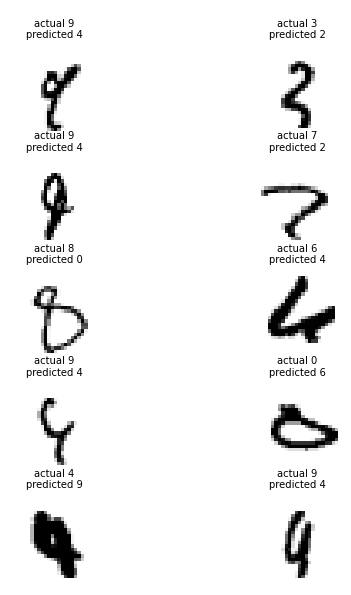

In [ ]:
wrong_predictions(test_loader, group_model,device=device)

Text(0.5, 1.0, 'Test Accuracy')

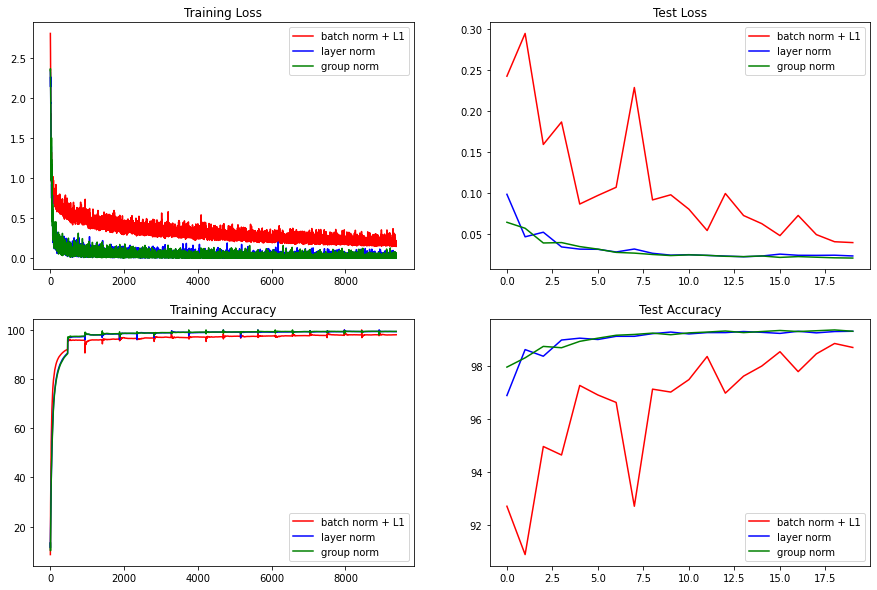

In [ ]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses_bn,'-r',label='batch norm + L1')
axs[0, 0].plot(train_losses_ln,'-b',label='layer norm')
axs[0, 0].plot(train_losses_gn,'-g',label='group norm')
axs[0, 0].legend(loc="upper right")
axs[0, 0].set_title("Training Loss")

axs[1, 0].plot(train_acc_bn,'r',label='batch norm + L1')
axs[1, 0].plot(train_acc_ln,'b',label='layer norm')
axs[1, 0].plot(train_acc_gn,'g',label='group norm')
axs[1, 0].legend(loc="lower right")
axs[1, 0].set_title("Training Accuracy")

epochs =[x for x in range(15)]
axs[0, 1].plot(test_losses_bn,'r',label='batch norm + L1')
axs[0, 1].plot(test_losses_ln,'b',label='layer norm')
axs[0, 1].plot(test_losses_gn,'g',label='group norm')
axs[0, 1].legend(loc="upper right")
axs[0, 1].set_title("Test Loss")

axs[1, 1].plot(test_acc_bn,'r',label='batch norm + L1')
axs[1, 1].plot(test_acc_ln,'b',label='layer norm')
axs[1, 1].plot(test_acc_gn,'g',label='group norm')
axs[1, 1].legend(loc="lower right")
axs[1, 1].set_title("Test Accuracy")